# 텍스트 생성

<img alt="LM Meta Learning" width="800" caption="During pretraining, language models are exposed to sequences of tasks that can be adapted during inference (courtesy of Tom B. Brown)" src="https://raw.githubusercontent.com/ChangSu-Choi/Natural-Language-Processing-with-Transformers/main/images/chapter05_lm-meta-learning.png?raw=1" id="lm-meta-learning"/>

위 그림은 언어 모델이 사전 훈련하는 동안 덧셈, 단어 철자 배열, 번역 같은 문맥 기반으로 다음 토큰을 예측하는 작업 시퀸스에 어떻게 노출되는지 보여줌. 이를 통해 얻은 지식은 미세 튜닝이나 추론 과정에서 효율적으로 적용됨

<img alt="Meena" width="300" caption="Meena on the left telling a corny joke to a human on the right (courtesy of Daniel Adiwardana and Thang Luong)" src="https://raw.githubusercontent.com/ChangSu-Choi/Natural-Language-Processing-with-Transformers/main/images/chapter05_meena.png?raw=1" id="meena"/>

## 일관성 있는 텍스트 생성의 어려움

시퀸스나 토큰 분류 같이 작업에 특화된 헤드에서 예측 생성은 간단한 반면, 모델의 확률 출력을 텍스트로 변환하려면 ***디코딩 방법(decoding method)*** 이 필요함.  
- 디코딩은 반복적으로 수행되므로 입력이 모델의 정방향 패스를 한 번 통과할 때 보다 많은 계산이 필요함.
- 생성된 텍스트의 품질과 다양성은 디코딩 방법과 이에 관련된 하이퍼 파라미터에 따라 달라짐.  
  

GPT-2의 사전 훈련 방법과 텍스트 생성에 적용하는 과정을 알아보겠음  
시작 프롬프트 또는 문맥 시퀸스 $x=x_1, x_2, ..x_k$ 가 주어질 때 텍스트에 등장하는 토큰 시퀸스 $y=y_1, y_2, ...y_t$ 의 확률 $P(y|x)$ 를 추정하도록 사전 훈련됨.  
직접 $P(y|x)$ 를 추정하기 위해 충분한 훈련 데이터를 획득하기란 불가능하므로, 일반적으로 확률의 연쇄 법칙(chain rule)을 사용해 조건부 확률의 곱으로 나타냄.  
$$P(y_1, ..., y_t|x)=\prod_{i=1}^NP(y_t|y_{<t},x)$$  
여기서 $y_{<t}$은 시퀸스 $y_1, ..., y_{t-1}$ 를 간략화 한 식임.  
<img alt="Text generation" width="700" caption="Generating text from an input sequence by adding a new word to the input at each step" src="https://raw.githubusercontent.com/ChangSu-Choi/Natural-Language-Processing-with-Transformers/main/images/chapter03_conditional-probability.png" id="text-generation"/>   
조건부 확률의 일반화 식을 문장의 확률 관점에서 다시 적어보면 문장의 확률은 각 단어들이 이전 단어가 주어졌을 때 다음 단어로 등장할 확률의 곱으로 구성됨 이 조건부 확률로 자기회귀 언어 모델링은 문장의 이전 단어가 주어지면 다음 단어를 예측한다는 직관을 얻을 수 있음. 앞선 식의 오른쪽 항에 위치한 확률이 이를 설명함.  
이런 사전 훈련 목표는 과거와 미래의 문맥을 모두 사용해 마스킹된 토큰을 예측하는 BERT와 매우 다름.  

<img alt="Text generation" width="700" caption="Generating text from an input sequence by adding a new word to the input at each step" src="https://raw.githubusercontent.com/ChangSu-Choi/Natural-Language-Processing-with-Transformers/main/images/chapter05_text-generation.png?raw=1" id="text-generation"/> 

이제 다음 토큰 예측 작업이 임의의 길이를 가진 텍스트 시퀸스를 생성할 때 어떻게 적용할지 예상이 됨.
'Transformers are the'같은 프롬프트로 시작하면 모델은 다음 토큰을 예측함. 다음 토큰이 결정되면 이를 프롬프트에 추가해 새로운 입력 시퀸스를 만들고 또 다른 토큰을 생성함. 이 과정을 특수한 시퀸스 종료 토큰이나 사전에 정의한 최대 길이에 도달할 때까지 반복함.  
이 과정의 핵심은 각 타임스텝에서 어떤 토큰을 선택할지 결정하는 디코딩 방법에 있음.  
언어 모델의 헤드는 각 스텝에서 어휘사전에 있는 토큰마다 logit $z_{t,i}$ 를 생성하므로 softmax를 적용하면 다음 토큰 $w_i$에 대한 확률 분포를 얻음.  
$$P(y_t=w_i|y_{<t}, x)=softmax(z_{t,i})$$  
대부분의 디코딩 방법은 다음과 같은 $\hat{y}$ 를 선택해 전체적으로 확률이 가장 높은 시퀸스를 찾음  
$$\hat{y}=\underset{x}{argmax}\,P(y|x)$$  
직접 $\hat{y}$를 찾으려면 언어 모델로 가능한 모든 시퀸스를 평가해야함. 이런 작업을 합리적인 시간 안에 할 수 있는 알고리즘이 없으므로 근사적인 방법을 사용함.

## 그리디 서치 디코딩

연속적인 모델 출력에서 이산적인 토큰을 얻는 가장 간단한 디코딩 방법은 각 타임스텝에서 확률이 가장 높은 토큰을 greedy로 선택하는 것임
$$\hat{y_t}=\underset{y_t}{argmax}\,P(y_t|y_{<t},x)$$  
그리디 서치 방법을 알아보기 위해 언어 모델링 헤더를 가진 15억개 파라미터의 GPT-2버전을 로드하겠음

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"

# 코랩의 경우 gpt2-xl을 사용하면 메모리 부족 에러가 발생함.
# 대신 "gpt" 또는 "gpt2-large"로 지정하거나 코랩 프로를 사용하세요.
model_name = "gpt2-xl"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

Downloading:   0%|          | 0.00/689 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.99G [00:00<?, ?B/s]

huggingface 트랜스포머는 GPT-2같은 자기회귀 모델을 위해 generate() 함수를 제공하지만, 작동 방식을 이해하기 위해 직접 디코딩 메서드를 구현하겠음

In [23]:
import pandas as pd

input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
iterations = []
n_steps = 8
choices_per_step = 5

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        # 첫 번째 배치의 마지막 토큰의 로짓을 선택해 소프트맥스를 적용합니다.
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        # 가장 높은 확률의 토큰을 저장합니다.
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice
        # 예측한 다음 토큰을 입력에 추가합니다.
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)
        
pd.DataFrame(iterations)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most (8.54%),only (4.96%),best (4.66%),Transformers (4.37%),ultimate (2.16%)
1,Transformers are the most,popular (16.78%),powerful (5.37%),common (4.96%),famous (3.72%),successful (3.19%)
2,Transformers are the most popular,toy (10.63%),toys (7.23%),Transformers (6.60%),of (5.46%),and (3.76%)
3,Transformers are the most popular toy,line (34.38%),in (18.21%),of (11.70%),brand (6.09%),line (2.69%)
4,Transformers are the most popular toy line,in (46.27%),of (15.09%),", (4.94%)",on (4.40%),ever (2.72%)
5,Transformers are the most popular toy line in,the (66.00%),history (12.40%),America (6.91%),Japan (2.44%),North (1.40%)
6,Transformers are the most popular toy line in the,world (69.25%),United (4.55%),history (4.29%),US (4.23%),U (2.30%)
7,Transformers are the most popular toy line in ...,", (39.73%)",. (30.65%),and (9.87%),with (2.32%),today (1.74%)


generate()함수를 사용하면 간단함

In [25]:
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=False)
print(tokenizer.decode(output[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Transformers are the most popular toy line in the world,


In [26]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, 
                               do_sample=False)
print(tokenizer.decode(output_greedy[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, Davis, and the University of Colorado, Boulder, were conducting a study on the Andean cloud forest, which is home to the rare species of cloud forest trees.


The researchers were surprised to find that the unicorns were able to communicate with each other, and even with humans.


The researchers were surprised to find that the unicorns were able


이 기사의 앞머리에 있는 몇 문장은 OpenAI가 작성한 기사와 매우 다를 뿐만 아니라 재미있게도 발견에 기여한 대학이 여러 곳임. 여기서 그리드 서치 디코딩의 주요 단점 하나가 드러나는데. 그리드 서치 알고리즘은 반복적인 출력 시퀸스를 생성하는 경향이 있어서 뉴스 기사로서는 확실히 적절치 않음.  

이는 그리드 서치 알고리즘의 보편적인 문제이며, 이로 인해 최적의 솔루션을 만들어내기 어려움. 디코딩 측면에서 보면, 확률이 높은 단어가 확률이 낮은 단어보다 먼저 등장하기 때문에 전체적으로 확률이 높은 단어 시퀸스를 생성하지 못하기 때문.  
- 그리디 서치 디코딩은 다양성이 필요한 텍스트 생성 작업에는 거의 사용되지 않지만, 결정적이고 사실적으로 정확한 출력이 필요한 수식 등의 짧은 문자 생성에는 유효함. 이런 작업을 위해 줄바꿈이 있는 *5 + 8 => 13 \n 7 + 2 => 9 \n 1 + 0 =>" 같은 형식의 입력 프롬프트를 제공해 GPT-2의 조건부 생성을 제어 할 수 있음.


더 나은 방법인 있는데. ***빔 서치 디코딩-beam search decoding*** 임

## 빔 서치 디코딩

빔 서치는 각 스텝에서 확률이 가장 높은 토큰을 디코딩하는 대신, 확률이 가장 높은 상위 b개의 다음 토큰을 추적함.  
여기서 b는 빔(beam) 또는 불완전 가설(partial hypothesis)의 개수임.  
다음 빔 세트는 기존 세트에서 가능한 모든 토큰을 확장하고 확률이 가장 높은 b개의 확장을 선택해 구성함. 이 과정은 최대 길이나 EOS 토큰에 도달할 때까지 반복됨.  
확률이 가장 높은 시퀸스는 로그 확률에 따라 b개의 빔의 순위를 매겨 선택됨.

<img alt="Beam search" width="700" caption="Beam search with two beams—the most probable sequences at each timestep are highlighted in blue" src="https://raw.githubusercontent.com/ChangSu-Choi/Natural-Language-Processing-with-Transformers/main/images/chapter05_beam-search.png?raw=1" id="beam-search"/> 

왜 확률이 아니라 로그 확률을 사용해 시퀸스 점수를 매길까?  
시퀸스의 전체 확률 $P(y_1, y_2, ...|x)$를 계산하려면 조건부 확률 $P(y_t|y_{t}, x)$의 곱을 계산 하여야 하기 때문임.  
각 조건부 확률이 일반적으로 [0, 1] 범위 안에 속한 작은 값이므로 이를 곱해 얻은 전체 확률은 쉽게 underflow가 발생함.  
컴퓨터가 이 계산의 결과를 더 이상 정확하게 표현 할 수 없다는 의미임.
 를 들어 t=1024개의 작은 토큰으로 이루어진 시퀸스에서 각 토큰의 확률을 0.5라고 하면

In [27]:
0.5 ** 1024

5.562684646268003e-309

이므로 시퀸스의 전체확률은 매우 작은 수가 됨  

이런 값은 수치적으로 불안정해 언더플로가 발생하지만, 로그 확률을 계산하면 이를 피할 수 있음.  
결합 확률(joint probablility)와 조건부 확률(conditional probability)에 로그를 적용하면 로그의 곱셈 규칙에 따라 다음과 같은 식이 나옴.  
$$logP(y_1, ...y_t|x)=\sum^N_{t=1}logP(y_t|y_{<t},x)$$  
다른 말로 하면, 앞서 본 확률의 곱셈이 로그 확률 덧셈으로 바뀜. 이 방식이 수치적 불안정을 일으킬 확률 이 훨씬 적음. 

In [28]:
import numpy as np

sum([np.log(0.5)] * 1024)

-709.7827128933695

이런 값이 더 다루기 쉬울 뿐 아니라 이 방식은 더 작은 수에도 적용됨. 상대적 확률만 비교하면 되므로 로그 확률을 사용해서도 비교가 가능함.  
  
그럼 그리디 서치와 빔 서치로 생성한 텍스트의 로그 확률을 계산해 빔 서치가 전체 확률을 향상하는지 확인 하겠음.  
허깅페이스 트랜스 포머 모델은 입력 토큰이 주어지면 다음 토큰에 대한 정규화되지 않은 로짓을 반환함. 따라서 먼저 로짓을 정규화해서 시퀸스의 각 토큰을 위해 전체 어휘사전에 대한 확률 분포를 만듬. 그다음 시퀸스에 있는 토큰 확률만 선택함. 이 단계를 구현한 함수는 다음과 같음

In [29]:
import torch.nn.functional as F

def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

이 함수는 하나의 토큰에 대한 로그 확률을 제공하므로, 시퀸스 전체 로그 확률을 얻으려면 각 토큰의 로그 확률을 더함

In [30]:
def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(
            output.logits[:, :-1, :], labels[:, 1:])
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy()

모델이 입력 시퀸스를 생성하지 않았으므로 입력 시퀸스의 로그 확률은 무시함. 또 로짓과 레이블의 정렬이 중요한데,  
모델은 다음 토큰을 예측하기 때문에 첫 번째 레이블에 대한 로짓을 얻지 못함. 또 마지막 로짓에 대한 정답이 없기 때문에 마지막 로짓은 필요하지 않음.  
  
이 함수를 사용해 OPEN AI 프롬프트에서 그리디 서치로 만든 시퀸스의 로그 확률을 계산하겠음

In [31]:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\n로그 확률: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, Davis, and the University of Colorado, Boulder, were conducting a study on the Andean cloud forest, which is home to the rare species of cloud forest trees.


The researchers were surprised to find that the unicorns were able to communicate with each other, and even with humans.


The researchers were surprised to find that the unicorns were able

로그 확률: -87.44


이를 빔 서치로 생성행 시퀸스와 비교.  
빔 개수를 지정하는데, 빔 크기가 클수록 결과가 더 좋을 가능성이 높지만 각 빔에 대해 병렬적으로 시퀸스를 생성하므로 생성 과정이 훨씬 느려짐

In [33]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, 
                             do_sample=False)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\n로그 확률: {logp:.2f}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The discovery of the unicorns was made by a team of scientists from the University of California, Santa Cruz, and the National Geographic Society.


The scientists were conducting a study of the Andes Mountains when they discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English

로그 확률: -55.23


하지만 빔 서치도 텍스트가 반복되는 문제가 있음. 이 문제를 해결하기 위해 no_repeat_ngram_szie 매개변수로 n-gram penalty를 부과하는 방법이 있는데,  
그러면 지금까지 n-gram을 추적해 이전에 보았던 n-gram을 생성하는 경우 다음 토큰 확률이 0이 됨

In [34]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, 
                             do_sample=False, no_repeat_ngram_size=2)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\n로그 확률: {logp:.2f}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The discovery was made by a team of scientists from the University of California, Santa Cruz, and the National Geographic Society.

According to a press release, the scientists were conducting a survey of the area when they came across the herd. They were surprised to find that they were able to converse with the animals in English, even though they had never seen a unicorn in person before. The researchers were

로그 확률: -93.13


반복적인 텍스트 생성은 막고 점수는 더 낮아졌지만 텍스트가 일관성을 유지함. n-gram 패널티를 사용한 빔 서치는 확률이 높은 토큰에 초점을 맞추는 빔 서치와 반복을 줄이는 n-gram 패널티의 균형을 잡는 좋은 방법임. 
- 사실적인 정확성을 요구하는 요약, 기계 번역 같은 애플리케이션에 널리 사용됨.
분야에 국한되지 않는 잡담이나 기사처럼 사실적인 정확성이 다양성보다 덜 중요할 때, 샘플링을 사용해 다양성을 늘리면서 반복을 줄이는 방법도 있음  
샘플링 방법을 몇가지 소개함

## 샘플링 방법

가장 간단한 샘플링 방법은 각 타임스탭 내에 모델이 출력한 전체 어휘사전의 확률 분포에서 랜덤하게 샘플링 하는 것임  
$$P(y_t=w_i|y_{<t},x)=softmax(z_{t,i})=\cfrac{\exp(z_{t,i})}{\sum^{|V|}_{j=1}\exp(z_{t,j})}$$    
여기서 $|V|$는 어휘사전의 cardinality를 나타냄. 소프트맥스 함수를 함수를 적용하기 전에 로짓의 스케일을 조정하는 온도 파라미터 T를 추가하면 출력의 다양성이 쉽게 제어됨  
$$P(y_t=w_i|y_{<t},x)=\cfrac{\exp(z_{t,i}/T)}{\sum^{|V|}_{j=1}\exp(z_{t,j}/T)}$$    
T값을 바꾸면 학률 분포의 형태가 제어됨. T<<1일 때 이 분포는 원점 근처에서 정점에 도달하고 드문 토큰을 억제함.  
반면 T>>1일 때 분포가 평평해지고 각 토큰의 확률이 동일해짐. 토큰  확률에 미치는 온도의 영향은 아래와 같음.

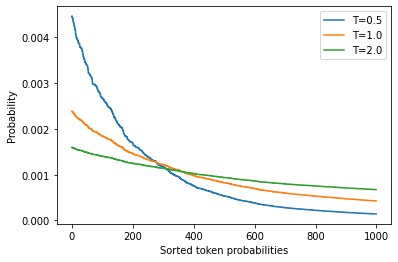

In [35]:
#세 개의 온도에서 랜덤하게 생성한 토큰 확률의 분포
import matplotlib.pyplot as plt
import numpy as np

def softmax(logits, T=1):
    e_x = np.exp(logits / T)
    return e_x / e_x.sum()

logits = np.exp(np.random.random(1000))
sorted_logits = np.sort(logits)[::-1]
x = np.arange(1000)

for T in [0.5, 1.0, 2.0]:
    plt.step(x, softmax(sorted_logits, T), label=f"T={T}")
plt.legend(loc="best")
plt.xlabel("Sorted token probabilities")
plt.ylabel("Probability")
plt.show()

temperature가 생성되는 텍스트에 어떤 영향을 미치는지 알아보기 위해 generate() 함수의 temperature 매개변수를 T=2로 지정해 샘플링을 해보겠음

In [42]:
torch.manual_seed(42);

In [43]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             temperature=2.0, top_k=0)
print(tokenizer.decode(output_temp[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


While the station aren protagonist receive Pengala nostalgiates tidbitRegarding Jenny loclonju AgreementCON irrational �rite Continent seaf A jer Turner Dorbecue WILL Pumpkin mere Thatvernuildagain YoAniamond disse * Runewitingkusstemprop});b zo coachinginventorymodules deflation press Vaticanpres Wrestling chargesThingsctureddong Ty physician PET KimBi66 graz Oz at aff da temporou MD6 radi iter


temparature가 높으니 횡설수설에 가까운 텍스트가 생성되었음. 드문 토큰이 강조되어 모델이 이상한 문법을 만들고 다양한 가짜단어를 만들어 냈음.  
temparature를 낮우면 어떻게 될까?  

In [44]:
torch.manual_seed(42);

In [45]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             temperature=0.5, top_k=0)
print(tokenizer.decode(output_temp[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The scientists were searching for the source of the mysterious sound, which was making the animals laugh and cry.


The unicorns were living in a remote valley in the Andes mountains

'When we first heard the noise of the animals, we thought it was a lion or a tiger,' said Luis Guzman, a researcher from the University of Buenos Aires, Argentina.


'But when


훨씬 일관성이 있게됨. 거기다 발견에 기여한 또 다른 대학도 언급됨.  
temparature은 샘플의 품질을 제어하지만, 항상 일관성(낮은 온도)과 다양성(높은 온도)의 균형점이 있기 때문에 당면한 문제에 따라 조정해야 함.

이 trade-off 관계를 조정하는 또 다른 방법으로는 어휘사전의 분포를 잘라내는 방법이 있음. 이 방법은 온도와 함께 다양성을 자유롭게 조정하지만, 더 제한된 범위에서 문맥상 매우 이상한 단어(즉, 확률이 낮은 단어)를 제외함. 대표적인 방법은 탑-k 샘플링(top-k sampling)과 뉴클리어스 샘플링(nucleus sampling or top-p sampling)임

## 탑-k 및 뉴클리어스 샘플링

탑-k와 뉴클리어스 샘플링은 temparature를 사용하는 방법에 대해 잘 알려진 두 가지 '대안' 또는 '확장'임  
두 샘플링은 모두 각 타임스텝에서 샘플링에 사용할 토큰의 개수를 줄인다는 개념에 기초함.  
작동 방식을 이해하기 위해 T=1에서 모델이 출력한 누적 확률 분포를 시각화 해보겠음

In [46]:
torch.manual_seed(42);

In [47]:
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

In [48]:
import torch.nn.functional as F

with torch.no_grad():
    output = model(input_ids=input_ids)
    next_token_logits = output.logits[:, -1, :]
    probs = F.softmax(next_token_logits, dim=-1).detach().cpu().numpy()

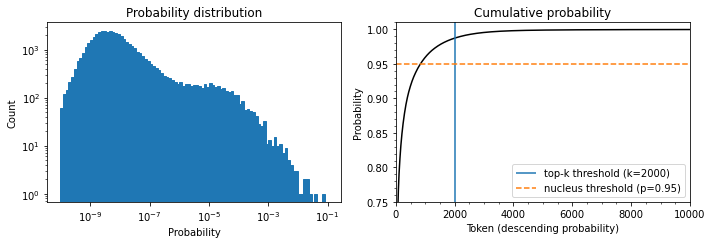

In [49]:
#다음 토큰 예측의 확률 분포(왼쪽)과 내림차순으로 정렬된 토큰 확률의 누적 분포
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].hist(probs[0], bins=np.logspace(-10, -1, 100), color="C0", edgecolor="C0")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("Probability distribution")
axes[0].set_xlabel("Probability")
axes[0].set_ylabel("Count")
#axes[0].grid(which="major")

axes[1].plot(np.cumsum(np.sort(probs[0])[::-1]), color="black")
axes[1].set_xlim([0, 10000])
axes[1].set_ylim([0.75, 1.01])
axes[1].set_title("Cumulative probability")
axes[1].set_ylabel("Probability")
axes[1].set_xlabel("Token (descending probability)")
#axes[1].grid(which="major")
axes[1].minorticks_on()
#axes[1].grid(which='minor', linewidth='0.5')
top_k_label = 'top-k threshold (k=2000)'
top_p_label = 'nucleus threshold (p=0.95)'
axes[1].vlines(x=2000, ymin=0, ymax=2, color='C0', label=top_k_label)
axes[1].hlines(y=0.95, xmin=0, xmax=10000, color='C1', label=top_p_label, linestyle='--')
axes[1].legend(loc='lower right')
plt.tight_layout()

왼쪽 그래프는 토큰 확률의 히스토그램임 $10^{-8}$ 근처가 최고 정점이고 $10^{-4}$ 근처에 조금 더 작은 제2의 정점 있음 그다음 $10^{-2}$와 $10^{-1}$ 사이의 확률을 가진 토큰에서 급격히 줄어드는데 가장 확률이 높은 토큰을 선택할 확률은 10분의 1임  
  

오른쪽 그래프는 내림차순 확률로 토큰을 정렬한 다음, 처음 10,000개의 토큰의 누적 합을 계산함. 이 곡선은 확률이 높은 토큰 중 하나를 선택할 확률을 나타냄. 예를 들어 확률이 가장 높은 1000개의 토큰 중 하나를 선택할 확률은 96%임. 확률이 빠르게 90%를 상회하지만 수천개의 토큰을 지나야 100%에 가깝게 수렴하게됨. 그래프를 보면 하위 8000개 토큰 중 하나를 선택할 확률은 약 100분의 1임  

이 수치는 처음에는 작아보이지만 텍스트를 생성할 때 토큰마다 한 번씩 샘플링 하기 때문에 중요함. 겨우 100분의 1, 1000분의 1이라도 수백번 샘플링 하게 되면 언젠간 희귀한 토큰을 선택할 가능성이 있음. 샘플링에서 이런 토큰을 선택하면 생성된 텍스트의 품질이 떨어지기도 함. 이런 이유로 확률이 매우 낮은 토큰을 피하기 위해서 top-k, top-p 샘플링이 등장함.  
  
탑-k 샘플링은 확률이 가장 높은 k개 토큰에서만 샘플링 해서 확률이 가장 낮은 토큰을 피함. 이렇게 하면 확률 분포의 롱테일(long-tail)을 잘라내고 확률이 가장 높은 토큰에서만 샘플링을 하는 것이 가능해짐 (수직선 확인)
매개변수 top-k 추가

In [50]:
torch.manual_seed(42);

In [51]:
output_topk = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             top_k=50)
print(tokenizer.decode(output_topk[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The wild unicorns roam the Andes Mountains in the region of Cajamarca, on the border with Argentina (Picture: Alamy/Ecole Nationale Supérieure d'Histoire Naturelle)

The researchers came across about 50 of the animals in the valley. They had lived in such a remote and isolated area at that location for nearly a thousand years that


가장 사람이 쓴 글 같음. 하지만 k값을 어떻게 정해야 할까? 수동으로 k값을 설정 했는데(정적) - cutoff  
대안으로 동적인 컷오프를 적용하는 방식이 있음. top-p 샘플링에서는 고정된 컷오프를 사용하지 않고 어디서 컷오프를 할지 조건으로 지정함. 이 조건은 선택한 특정 확률 질량(probability mass)에 도달 할 때임.  
95%라고 설정하면 내림차순으로 토큰을 정렬한 다음 토큰들의 확률 값들의 총 합이 95%에 도달할때까지 리스트의 맨 위부터 토큰을 하나씩 추가함.
매개변수 top_p를 사용

In [52]:
torch.manual_seed(42);

In [53]:
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             top_p=0.90)
print(tokenizer.decode(output_topp[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The scientists studied the DNA of the animals and came to the conclusion that the herd are descendants of a prehistoric herd that lived in Argentina about 50,000 years ago.


According to the scientific analysis, the first humans who migrated to South America migrated into the Andes Mountains from South Africa and Australia, after the last ice age had ended.


Since their migration, the animals have been adapting to


top-p 또한 일관성 있는 텍스트를 생성하였음. 두 샘플링 방법을 연결하면 양쪽의 장점을 모두 취할수 있는데  
top_k=50와 top_p=0.9로 지정하면 확률이 가장 높은 50개 토큰에서 확률 질량이 90%인 토큰을 선택하게 됨.  
  

샘플링 할 때 빔 서치를 적용하는 방법도 있는데, 다음 후보 토큰의 배치를 탐욕적으로 선택하지 않고 샘플링을 통해 같은 식으로 빔 세트를 구성하는 방식임

## 어떤 디코딩 방법이 최선일까요?

언제나 통하는 최선의 디코딩 방식은 없음. 최선의 방법은 주어진 텍스트 생성 작업의 특성에 따라 다름.
- 수식이나 특정 질문에 답을 내듯 정밀한 작업을 수행하는 모델: T를 낮추거나 확률이 가장 높은 답을 보장하기 위해 빔 서치와 그리디 서치 같은 결정적인 방법 사용
- 모델이 더 길고 창의적인 텍스트를 생성: 샘플링 방법으로 바꾸고 T를 올리거나 top-k와 top-p를 혼합해 사용

## 결론